In [1]:
import numpy as np
import pandas as pd
import os

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
%matplotlib inline

# Figures 4 & 5. Validate CSDL against NASS county statistics

Here we create Figures 4 & 5 from the paper, which summarize the agreement between CSDL and NASS statistics at the county level. CDL and NASS agreement is also shown for comparision.

In [2]:
# if needed, change these to the directories containing your data and the name of your data file
nass_dir = '../data/nass_counties/'
cdl_dir = '../data/cdl_counties/'
csdl_dir = '../data/csdl_counties/'

## Step 1. Load Datasets

### 1.1. NASS county-level statistics

First, we load the NASS county-level statistics from 1999-2018.

In [3]:
nass_corn = pd.read_csv(os.path.join(nass_dir, 'NASS_cropAreaCorn_1999to2018_raw.csv'))
nass_soy = pd.read_csv(os.path.join(nass_dir, 'NASS_cropAreaSoy_1999to2018_raw.csv'))

cols = ['state_fips_code', 'county_code', 'year', 'state_alpha', 
        'class_desc', 'short_desc','statisticcat_desc', 'commodity_desc',
        'util_practice_desc', 'Value']
nass_soy = nass_soy[cols]
nass_corn = nass_corn[cols]
nass = pd.concat([nass_corn, nass_soy])
print(nass.shape)
nass.head()

(39986, 10)


,state_fips_code,county_code,year,state_alpha,class_desc,short_desc,statisticcat_desc,commodity_desc,util_practice_desc,Value
0,18,7,2018,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"120,000"
1,18,7,2017,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"123,000"
2,18,7,2016,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"125,000"
3,18,7,2015,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"129,000"
4,18,7,2014,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"130,000"


In [4]:
# Add the unique county FIPS code: stateFIPS+countyFIPS
nass['county_code'] = nass['county_code'].map(int).apply(lambda x: '{0:0>3}'.format(x))
nass['state_fips_code'] = nass['state_fips_code'].apply(lambda x: '{0:0>2}'.format(x))
nass['fips'] = (nass['state_fips_code'].map(str)+nass['county_code'].map(str)).map(int)

nass['commodity_desc'] = nass['commodity_desc'].str.title()
nass = nass.rename(columns={"commodity_desc":"crop", "state_alpha":"state", "Value":"Nass_Area_acres"})
nass['Nass_Area_acres'] = nass['Nass_Area_acres'].str.replace(',', '').astype('float')
nass["Nass_Area_m2"] = nass["Nass_Area_acres"] * 4046.86
nass = nass[['fips', 'year', 'state', 'crop', 'Nass_Area_m2']]
nass.head()

,fips,year,state,crop,Nass_Area_m2
0,18007,2018,IN,Corn,485623200.0
1,18007,2017,IN,Corn,497763780.0
2,18007,2016,IN,Corn,505857500.0
3,18007,2015,IN,Corn,522044940.0
4,18007,2014,IN,Corn,526091800.0


### 1.2. Aggregated CDL at county level

Next, we load CDL aggregated to the county level across the 13 states from 1999-2018. This data was exported in Google Earth Engine. A few steps of reorganizing the dataframe allows us to compare it to the NASS data.

In [5]:
cdl = pd.DataFrame()
for filename in sorted(os.listdir(cdl_dir)):
    if (filename.endswith('.csv')):
        temp = pd.read_csv(os.path.join(cdl_dir, filename)).drop(['.geo','system:index'],axis=1)
        cdl = pd.concat([temp, cdl], sort=True)
cdl = cdl[cdl['masterid'] != 0] # drop dummy feature
print(cdl.shape)
cdl.head()

(23500, 141)


,0,1,10,11,111,112,12,121,122,123,...,82,83,87,88,92,COUNTYFP,STATEFP,Year,area_m2,masterid
1,NaN,2.422260e+07,NaN,NaN,6.784978e+07,NaN,NaN,6.291375e+07,3.130033e+07,4.413511e+06,...,NaN,NaN,NaN,NaN,1.265582e+03,141,26,2018,6.647720e+09,26141
2,NaN,2.773798e+07,NaN,NaN,5.550784e+07,NaN,NaN,5.950816e+07,3.463783e+07,1.036972e+07,...,NaN,NaN,NaN,NaN,1.904327e+03,7,26,2018,4.380054e+09,26007
3,NaN,1.263960e+07,NaN,NaN,5.533375e+07,NaN,NaN,8.084768e+07,1.961116e+07,1.536571e+06,...,NaN,NaN,NaN,NaN,NaN,1,26,2018,4.627665e+09,26001
4,NaN,6.707903e+05,NaN,NaN,4.359223e+07,NaN,NaN,1.167421e+08,4.196676e+07,1.107926e+07,...,NaN,NaN,NaN,NaN,2.143770e+06,33,26,2018,6.971253e+09,26033
5,NaN,4.440057e+06,NaN,NaN,1.729813e+07,NaN,NaN,8.438341e+07,2.201878e+07,1.366202e+06,...,NaN,NaN,NaN,NaN,NaN,135,26,2018,1.477202e+09,26135


In [6]:
# compute CDL coverage by county
classes = list(set(cdl.columns.tolist()) - set(['Year', 'area_m2', 'masterid', 'COUNTYFP', 'STATEFP']))
other = list(set(classes) - set(['1', '5']))
cdl['cdl_coverage'] = cdl[classes].sum(axis=1)
cdl['Other'] = cdl[other].sum(axis=1)
cdl = cdl.drop(other, axis=1)
cdl.head()

,1,5,COUNTYFP,STATEFP,Year,area_m2,masterid,cdl_coverage,Other
1,2.422260e+07,4.399447e+07,141,26,2018,6.647720e+09,26141,1.774092e+09,1.705875e+09
2,2.773798e+07,5.445810e+07,7,26,2018,4.380054e+09,26007,1.536184e+09,1.453988e+09
3,1.263960e+07,1.282222e+07,1,26,2018,4.627665e+09,26001,1.798655e+09,1.773194e+09
4,6.707903e+05,5.159425e+05,33,26,2018,6.971253e+09,26033,4.074761e+09,4.073575e+09
5,4.440057e+06,1.957263e+06,135,26,2018,1.477202e+09,26135,1.480376e+09,1.473978e+09


In [7]:
maxcoverage = cdl[cdl['Year'] == 2018][['masterid', 'cdl_coverage']].rename(
    {'cdl_coverage': '2018cdl_coverage'}, axis=1)
cdl = cdl.merge(maxcoverage, on='masterid')
cdl['CDL_perccov'] = cdl['cdl_coverage'] / cdl['2018cdl_coverage'] * 100
cdl_key = {'1': "Corn", '5': "Soybeans", 'Year': "year"}  
cdl = cdl.rename(cdl_key, axis=1)
cdl.head()

,Corn,Soybeans,COUNTYFP,STATEFP,year,area_m2,masterid,cdl_coverage,Other,2018cdl_coverage,CDL_perccov
0,2.422260e+07,4.399447e+07,141,26,2018,6.647720e+09,26141,1.774092e+09,1.705875e+09,1.774092e+09,100.0
1,2.593412e+07,3.195660e+07,141,26,2017,6.647720e+09,26141,1.774092e+09,1.716201e+09,1.774092e+09,100.0
2,2.158034e+07,3.033726e+07,141,26,2016,6.647720e+09,26141,1.774092e+09,1.722174e+09,1.774092e+09,100.0
3,3.354098e+07,3.151936e+07,141,26,2015,6.647720e+09,26141,1.774092e+09,1.709031e+09,1.774092e+09,100.0
4,2.505473e+07,3.652269e+07,141,26,2014,6.647720e+09,26141,1.774092e+09,1.712514e+09,1.774092e+09,100.0


In [8]:
crops = ["Corn", "Soybeans", "Other"]
cdl = pd.melt(cdl, id_vars=['masterid', 'year', 'COUNTYFP', 'STATEFP', 'CDL_perccov'], value_vars=crops, value_name='CDL_Area_m2')
cdl = cdl.rename(columns={"variable": "crop", "masterid": "fips"})
cdl.head()

,fips,year,COUNTYFP,STATEFP,CDL_perccov,crop,CDL_Area_m2
0,26141,2018,141,26,100.0,Corn,2.422260e+07
1,26141,2017,141,26,100.0,Corn,2.593412e+07
2,26141,2016,141,26,100.0,Corn,2.158034e+07
3,26141,2015,141,26,100.0,Corn,3.354098e+07
4,26141,2014,141,26,100.0,Corn,2.505473e+07


### 1.3. Aggregated CSDL at county level

Lastly, we load CSDL aggregated to the county level, also data that was exported from GEE.

In [9]:
csdl = pd.DataFrame()
for filename in sorted(os.listdir(csdl_dir)):
    if (filename.endswith('.csv')):
        temp = pd.read_csv(os.path.join(csdl_dir, filename))
        csdl = pd.concat([temp, csdl], sort=True)
csdl = csdl.dropna(subset=['masterid'])
csdl[['COUNTYFP', 'STATEFP', 'masterid', 'year']] = csdl[['COUNTYFP', 'STATEFP', 'masterid', 'year']].astype(int)
csdl = csdl[['0', '1', '5', 'COUNTYFP', 'STATEFP', 'masterid', 'year']]
print(csdl.shape)
csdl.head()

(23500, 7)


,0,1,5,COUNTYFP,STATEFP,masterid,year
0,4.881476e+09,2.169119e+07,3.093218e+07,141,26,26141,2018
1,2.895083e+09,3.016545e+07,4.841399e+07,7,26,26007,2018
2,2.839890e+09,1.271390e+07,1.660682e+07,1,26,26001,2018
3,3.111620e+09,1.267601e+05,4.735479e+04,33,26,26033,2018
4,NaN,3.773565e+06,1.041173e+06,135,26,26135,2018


In [10]:
csdl = csdl.merge(maxcoverage, on='masterid')
csdl['CSDL_coverage'] = csdl[['0','1','5']].sum(axis=1)
csdl['CSDL_perccov'] = csdl['CSDL_coverage'] / csdl['2018cdl_coverage']*100
# note that CDL covers lakes, rivers; CSDL does not
csdl_key = {'0':"Other",'1': "Corn", '5': "Soybeans"} 
csdl = csdl.rename(csdl_key,axis=1)
csdl.head()

,Other,Corn,Soybeans,COUNTYFP,STATEFP,masterid,year,2018cdl_coverage,CSDL_coverage,CSDL_perccov
0,4.881476e+09,2.169119e+07,3.093218e+07,141,26,26141,2018,1.774092e+09,4.934100e+09,278.119777
1,4.881476e+09,3.095058e+07,3.207334e+07,141,26,26141,2017,1.774092e+09,4.944500e+09,278.706024
2,4.881476e+09,2.718304e+07,2.382351e+07,141,26,26141,2016,1.774092e+09,4.932483e+09,278.028642
3,4.881476e+09,3.057450e+07,2.438978e+07,141,26,26141,2015,1.774092e+09,4.936441e+09,278.251727
4,4.881476e+09,4.042442e+07,2.803766e+07,141,26,26141,2014,1.774092e+09,4.949938e+09,279.012556


In [11]:
crops = ["Corn", "Soybeans", "Other"]
csdl = pd.melt(csdl, id_vars=['masterid', 'year', 'COUNTYFP', 'STATEFP', 'CSDL_perccov'], value_vars=crops, value_name='CSDL_Area_m2')
csdl = csdl.rename(columns={"variable": "crop", "masterid": "fips"})
csdl.head()

,fips,year,COUNTYFP,STATEFP,CSDL_perccov,crop,CSDL_Area_m2
0,26141,2018,141,26,278.119777,Corn,2.169119e+07
1,26141,2017,141,26,278.706024,Corn,3.095058e+07
2,26141,2016,141,26,278.028642,Corn,2.718304e+07
3,26141,2015,141,26,278.251727,Corn,3.057450e+07
4,26141,2014,141,26,279.012556,Corn,4.042442e+07


### 1.4. Join CDL, CSDL and NASS

In [12]:
df = nass.merge(cdl, on=['year', 'fips', 'crop'], how='left').merge(
    csdl, on=['year', 'fips', 'crop', 'COUNTYFP', 'STATEFP'], how='left')

# convert m2 to km2: 1e6
df['Nass_Area_km2'] = df['Nass_Area_m2'] / 1e6
df['CDL_Area_km2'] = df['CDL_Area_m2'] / 1e6
df['CSDL_Area_km2'] = df['CSDL_Area_m2'] / 1e6

print(df.shape)
df.head()

(39986, 14)


,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2,Nass_Area_km2,CDL_Area_km2,CSDL_Area_km2
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,91.866776,5.355468e+08,485.62320,454.688856,535.546790
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,91.523431,4.923180e+08,497.76378,497.837007,492.317984
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,91.367605,5.099034e+08,505.85750,486.721443,509.903359
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,91.585821,5.375621e+08,522.04494,526.146558,537.562065
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,91.096214,5.464948e+08,526.09180,510.443416,546.494803


## Step 2. Generate Figure 4: comparing  NASS-CSDL

In [13]:
recent_years = np.arange(2008, 2019)
past_years = np.arange(1999, 2008)
df['year_group'] = '1999-2007'
df.loc[df['year'].isin(recent_years),'year_group'] = '2008-2018'

df_sub = df[df['CDL_perccov'] > 95]
print(df.shape)
print(df_sub.shape)

(39986, 15)
(28948, 15)


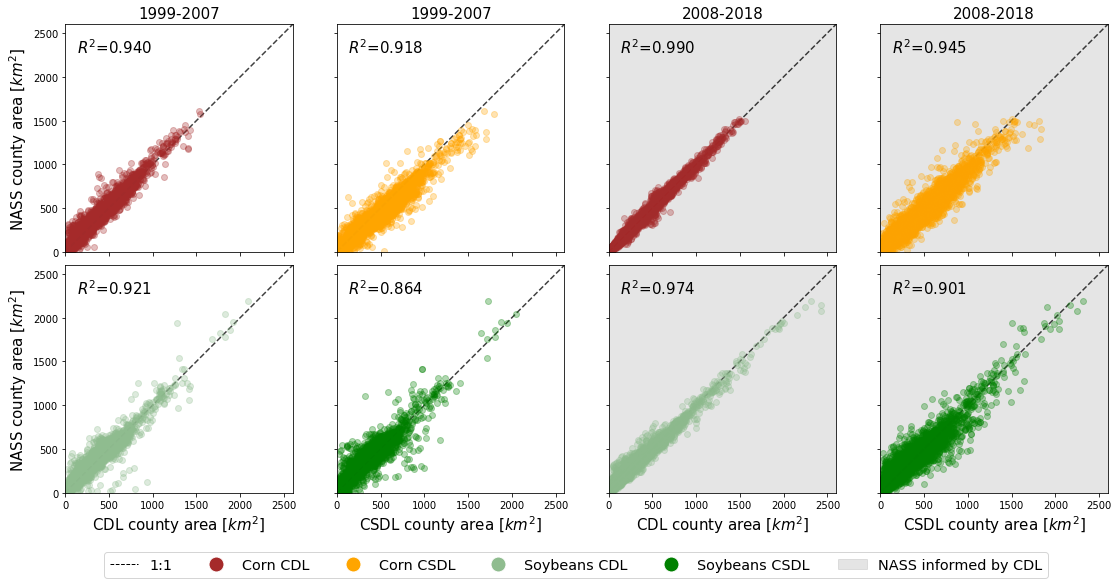

In [14]:
color_mapCSDL = { "Corn": 'orange',  "Soybeans": 'green'}
color_mapCDL = { "Corn": 'brown',  "Soybeans": 'darkseagreen'}
fsize = 15

lm = linear_model.LinearRegression()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)

fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16,8))

for i,(id,group) in enumerate(df_sub[df_sub['year_group']=='1999-2007'].groupby(['crop'])):
            
    ax[i,0].scatter(group['CDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCDL[id], alpha=0.3, label=id)
    ax[i,1].scatter(group['CSDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCSDL[id], alpha=0.3, label=id)

    group1= group.dropna(subset=['CDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group1['CDL_Area_km2'].values,group1['Nass_Area_km2'].values)
    ax[i,0].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,0].transAxes)

    group2= group.dropna(subset=['CSDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group2['CSDL_Area_km2'].values,group2['Nass_Area_km2'].values)
    ax[i,1].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,1].transAxes)

    lims = [0,2.6e+9/1e6] # km2
    # now plot both limits against each other
    ax[i,0].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,1].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,0].set_xlim(lims)
    ax[i,1].set_xlim(lims)
    ax[i,0].set_ylim(lims)
    ax[i,1].set_ylim(lims)  
    ax[i,0].set_aspect('equal')
    ax[i,1].set_aspect('equal')
    ax[0,0].set_xticklabels('', rotation=90)
    ax[0,1].set_xticklabels('', rotation=90)
    ax[i,1].set_yticklabels('', rotation=90)

for i,(id,group) in enumerate(df_sub[df_sub['year_group']=='2008-2018'].groupby(['crop'])):
       
    ax[i,2].scatter(group['CDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCDL[id], alpha=0.3, label=id)
    ax[i,3].scatter(group['CSDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCSDL[id], alpha=0.3, label=id)
    
    # set background to gray and alpha=0.2
    ax[i,2].set_facecolor((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2))
    ax[i,3].set_facecolor((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2))
    
    group1= group.dropna(subset=['CDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group1['CDL_Area_km2'].values, group1['Nass_Area_km2'].values)
    ax[i,2].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,2].transAxes)

    group2= group.dropna(subset=['CSDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group2['CSDL_Area_km2'].values, group2['Nass_Area_km2'].values)
    ax[i,3].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,3].transAxes)

    lims = [0,2.6e+9/1e6] # area in km2
    # now plot both limits against each other
    ax[i,2].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,3].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,2].set_xlim(lims)
    ax[i,3].set_xlim(lims)
    ax[i,2].set_ylim(lims)
    ax[i,3].set_ylim(lims)    
    ax[i,2].set_aspect('equal')
    ax[i,3].set_aspect('equal')
    ax[0,2].set_xticklabels('', rotation=90)
    ax[0,3].set_xticklabels('', rotation=90)
    ax[i,2].set_yticklabels('', rotation=90)
    ax[i,3].set_yticklabels('', rotation=90)

ax[0,0].set_ylabel('NASS county area [$km^2$]',fontsize=fsize)    
ax[1,0].set_ylabel('NASS county area [$km^2$]',fontsize=fsize)   
ax[1,0].set_xlabel('CDL county area [$km^2$]',fontsize=fsize)
ax[1,1].set_xlabel('CSDL county area [$km^2$]',fontsize=fsize)
ax[1,2].set_xlabel('CDL county area [$km^2$]',fontsize=fsize)
ax[1,3].set_xlabel('CSDL county area [$km^2$]',fontsize=fsize)
ax[0,0].set_title('1999-2007',fontsize=fsize) 
ax[0,1].set_title('1999-2007',fontsize=fsize) 
ax[0,2].set_title('2008-2018',fontsize=fsize) 
ax[0,3].set_title('2008-2018',fontsize=fsize) 

# Create the legend
legend_elements = [ Line2D([0], [0], color='k', linewidth=1, linestyle='--', label='1:1'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=15, label='Corn CDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=15, label='Corn CSDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkseagreen', markersize=15, label='Soybeans CDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Soybeans CSDL'),
                    mpatches.Patch(facecolor='gray', edgecolor='gray', alpha = 0.2, label='NASS informed by CDL')]
fig.legend(handles=legend_elements,
           loc='lower center',  
           bbox_to_anchor=(0.5,-0.01),
           fontsize = 'x-large',
           ncol=7)

fig.tight_layout(rect=[0,0.05,1,1]) # legend on the bottom

## Step 3. Generate Figure 5: comparing NASS and CSDL over time by state 

In [15]:
def corrfun(df, col1, col2):
    
    df = df.dropna(subset=[col2])
    
    if df.shape[0] != 0:
        r2 = r2_score(df[col1].values, df[col2].values)
        mse = mean_squared_error(df[col1].values, df[col2].values)
    else:
        r2 = np.nan
        mse = np.nan
        
    return pd.Series({'R': r2, 'mse': mse, 'Ncounties': df.shape[0]}) # return R2 (coef of determination)

In [16]:
totArea = df.groupby(['year', 'state', 'crop'])['Nass_Area_m2', 'CDL_Area_m2', 'CSDL_Area_m2'].sum().reset_index()
print(totArea.shape) # 20years * 13states * 2commodity = 520 rows
corr_cdl = df[df['CDL_perccov'] > 90].groupby(['state','year','crop']).apply(corrfun,'Nass_Area_m2','CDL_Area_m2').reset_index().rename(
    {'R': 'R_NASS_CDL', 'mse': 'mse_NASS_CDL', 'Ncounties': 'Ncounties_CDL'}, axis=1)
corr_csdl = df.groupby(['state','year','crop']).apply(corrfun, 'Nass_Area_m2', 'CSDL_Area_m2').reset_index().rename(
    {'R': 'R_NASS_CSDL', 'mse': 'mse_NASS_CSDL', 'Ncounties': 'Ncounties_CSDL'}, axis=1)
corr = corr_cdl.merge(corr_csdl, on=['state','year','crop'], how='outer')
corr = corr.merge(totArea, on=['state','year','crop'], how='left')
print(corr.shape)

abbr_to_state = {'IL':'Illinois', 'IA':'Iowa', 'IN':'Indiana', 'NE':'Nebraska', 'ND':'North Dakota',
                 'SD':'South Dakota', 'MN':'Minnesota', 'WI':'Wisconsin', 'MI':'Michigan',
                 'KS':'Kansas','KY':'Kentucky', 'OH':'Ohio', 'MO':'Missouri'}
corr['state_abbrs'] = corr['state']
corr['state_name'] = corr['state'].replace(abbr_to_state)
corr.head()

(520, 6)
(520, 12)


,state,year,crop,R_NASS_CDL,mse_NASS_CDL,Ncounties_CDL,R_NASS_CSDL,mse_NASS_CSDL,Ncounties_CSDL,Nass_Area_m2,CDL_Area_m2,CSDL_Area_m2,state_abbrs,state_name
0,IA,2000,Corn,0.959916,1.840572e+15,84.0,0.774614,9.264682e+15,99.0,4.977638e+10,4.474088e+10,5.392250e+10,IA,Iowa
1,IA,2000,Soybeans,0.929407,2.348138e+15,84.0,0.802724,6.156983e+15,99.0,4.330140e+10,4.005790e+10,4.045228e+10,IA,Iowa
2,IA,2001,Corn,0.855639,6.123710e+15,99.0,0.944908,2.336956e+15,99.0,4.734826e+10,4.763744e+10,4.600080e+10,IA,Iowa
3,IA,2001,Soybeans,0.750873,8.880001e+15,99.0,0.946944,1.891139e+15,99.0,4.451546e+10,4.372346e+10,4.698286e+10,IA,Iowa
4,IA,2002,Corn,0.909704,3.533140e+15,99.0,0.897344,4.016762e+15,99.0,4.937169e+10,4.719149e+10,5.111006e+10,IA,Iowa


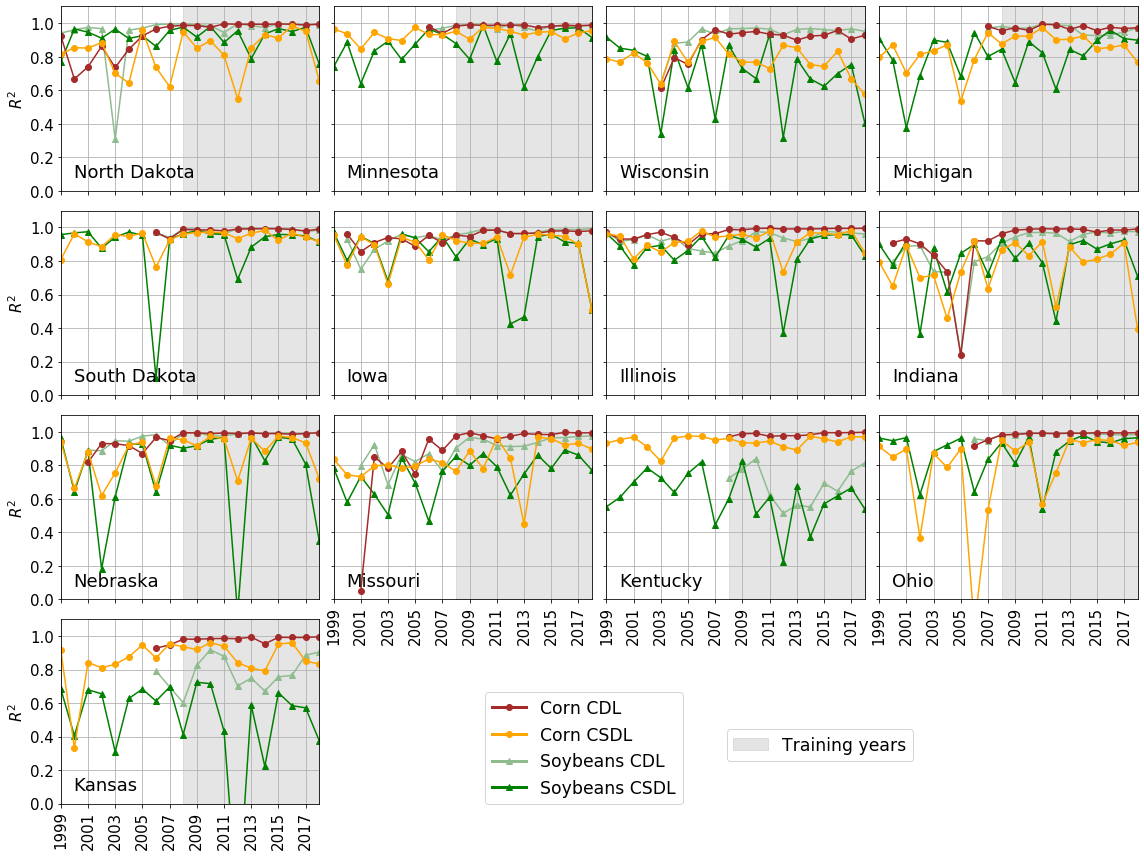

In [17]:
state_geosorted = ['North Dakota', 'Minnesota', 'Wisconsin', 'Michigan',
 'South Dakota','Iowa', 'Illinois', 'Indiana',
 'Nebraska', 'Missouri', 'Kentucky', 'Ohio',
 'Kansas']

color_mapCSDL = { "Corn": 'orange',  "Soybeans": 'green'}
color_mapCDL = { "Corn": 'brown',  "Soybeans": 'darkseagreen'}
marker_map ={ "Corn": 'o',  "Soybeans": '^'}
fsize = 15
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(16,12))

for i, id in enumerate(state_geosorted):
    
    group = corr[corr['state_name']==id]

    thisAx = ax[int(np.floor(i/4)), i%4]
    thisAx.text(0.05, 0.1, id, ha="left", va="center", size=18, bbox=bbox_props, transform=thisAx.transAxes)
    
    ylabels = np.arange(0, 12, 2)/10
    thisAx.set_yticks(ylabels)
    thisAx.set_yticklabels('', rotation=0)
    
    xlabels = np.arange(1999, 2019, 2)
    thisAx.set_xticks(xlabels)
    thisAx.set_xticklabels('', rotation=90)
    thisAx.fill_between(np.arange(2008, 2019), 0, 1.1, alpha = 0.2, color='gray')

    crops = ['Soybeans','Corn']
    for l,id2 in enumerate(crops):
        group2 = group[group['crop']==id2]
        group2 = group2.sort_values('year')
        
        thisAx.plot(group2['year'],group2['R_NASS_CDL'],color=color_mapCDL[id2], alpha=1, marker=marker_map[id2])
        thisAx.plot(group2['year'],group2['R_NASS_CSDL'],color=color_mapCSDL[id2], alpha=1, marker=marker_map[id2])

    thisAx.set_xlim([1999,2018])
    thisAx.set_ylim([0.0, 1.1])
    thisAx.grid(True)

ax[0,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[1,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[2,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[3,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[0,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[1,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[2,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[3,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[3,0].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[-1,-1].axis('off')
ax[-1,-2].axis('off')
ax[-1,-3].axis('off')

# Create the legend manually
legend_elements = [ Line2D([0], [0], color='brown',  linewidth=3, marker='o', linestyle='-', label='Corn CDL'),
                    Line2D([0], [0], color='orange',  linewidth=3, marker='o', linestyle='-', label='Corn CSDL'),
                    Line2D([0], [0], color='darkseagreen',  linewidth=3, marker='^', linestyle='-', label='Soybeans CDL'),
                    Line2D([0], [0], color='green',  linewidth=3, marker='^', linestyle='-', label='Soybeans CSDL')]
fig.legend(handles=legend_elements,
           loc="lower right",   # Position of legend
           bbox_to_anchor=(0.6, 0.05),
           fontsize = 'xx-large')

bckground_patch = mpatches.Patch(color='gray', alpha = 0.2, label='Training years')
fig.legend(handles=[bckground_patch],
           loc="lower right",
           bbox_to_anchor=(0.8, 0.1),
           fontsize = 'xx-large')

fig.tight_layout()
ax[2,1].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[2,2].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[2,3].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
fig.show()